In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from mvextractor.videocap import VideoCap
import subprocess
from tqdm import tqdm
import ffmpeg
%matplotlib inline

2023-05-05 12:50:55.558707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 12:50:56.550816: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-05-05 12:50:56.550876: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-05-05 12:50:56.550898: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-05-05 12:50:57.800070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 12:50:57.898960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 12:50:57.899137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Helper Functions

In [3]:
def show(image):
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

def generate_base_sample(img,scale):
    dim = (int(image.shape[1]*scale),int(image.shape[0]*scale))
    return cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)

def process_input(image, input_size, upscale_factor):
    img /= 255.0
    img = cv2.cvtColor(image,cv2.COLOR_BGR2YUV)
    return img

## Codebase

In [4]:
model = tf.keras.models.load_model("./models/ESPCNv1_2x/")

2023-05-05 12:50:57.955764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 12:50:57.956691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 12:50:57.956845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-05 12:50:57.956956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 separable_conv2d (Separable  (None, None, None, 64)   153       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, None, None, 64)   4736      
 leConv2D)                                                       
                                                                 
 separable_conv2d_2 (Separab  (None, None, None, 32)   2656      
 leConv2D)                                                       
                                                                 
 separable_conv2d_3 (Separab  (None, None, None, 4)    420       
 leConv2D)                                                   

### SR Forward Pass

In [6]:
def sr(frame,scale_factor= 3):
    y,u,v = cv2.split(frame)
    y = np.expand_dims(np.expand_dims(y,axis=-1),axis=0)
    print(y.shape)
    y = y/255
    y_out = model(y).numpy()
    u = cv2.resize(u, (u.shape[1]*2,u.shape[0]*2), interpolation=cv2.INTER_CUBIC)
    v = cv2.resize(v, (v.shape[1]*2,v.shape[0]*2), interpolation=cv2.INTER_CUBIC)
    y_out = np.squeeze(np.squeeze(y_out,axis=-1),axis=0)
    y_out *= 255.0
    y_out = y_out.clip(0, 255)
    print("Shapes y:",y_out.shape,"| u:",u.shape,"| v:",v.shape)
    return cv2.merge((np.uint8(y_out),u,v))

### Key-Frame SR

In [7]:
video = VideoCap()
success = video.open("data/short_lowres.mp4")
# success = video.open("data/Short.mp4")
prev_frame = None
i_frames = []
high_res_frames = []
motion_vectors = []
if success:
    while video.grab():
        success, frame, motion_data, frame_type, timestamp = video.retrieve()
        if(frame_type == "I"):
            i_frames.append(sr(frame))
        elif(frame_type == "P"):
            motion_vectors.append(motion_data)
video.release()

(1, 360, 640, 1)


2023-05-05 11:40:20.002332: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2023-05-05 11:40:20.060282: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2023-05-05 11:40:20.091786: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2023-05-05 11:40:20.115821: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2023-05-05 11:40:20.133628: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


Shapes y: (720, 1280) | u: (720, 1280) | v: (720, 1280)


In [8]:
i_frames = np.array(i_frames)
motion_vectors = np.array(motion_vectors, dtype=object)

In [9]:
i_frames.shape

(1, 720, 1280, 3)

In [10]:
len(motion_vectors)

193

In [11]:
scaled_motion_vector=motion_vectors*2

<h2>Dataset (Mode 1)</h2>

In [39]:
i_frame = i_frames[0]

In [40]:
# i_frames_reshaped = i_frames.reshape(-1,3)
# df_list = []
# for i, row in enumerate(i_frames_reshaped):
#     print(i)
#     df_dict = {}
#     df_dict["frame_id"] = i
#     df_dict["r"] = row[0]
#     df_dict["g"] = row[1]
#     df_dict["b"] = row[2]
#     df_dict["motion_vector"] = motion_vectors[i]
#     df_list.append(df_dict)

# import pandas as pd
# df = pd.DataFrame(df_list)


<h2>Dataset (Mode 2)</h2>

In [15]:
np.savez("data/i_frames.npz", i_frames=i_frames)
import pandas as pd
# df = pd.DataFrame({"motion_vectors": motion_vectors})
np.savez("data/motion_vectors.npz", motion_vectors=motion_vectors)

In [ ]:
mv.shape

(945, 10)

In [48]:
mv[0]

array([-1, 16, 16,  8,  8,  8,  8,  0,  0,  4], dtype=int32)

# SISR Testing

In [28]:
# fig, axs = plt.subplots(3, 3,figsize=(18, 18))
# for i in range(3):
#     for j in range(3):
#         axs[i, j].imshow(cv2.cvtColor(i_frames[i*3+j],cv2.COLOR_BGR2RGB))
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
# plt.savefig("results/key_frames.png",pad_inches=0,bbox_inches='tight')
# plt.show()

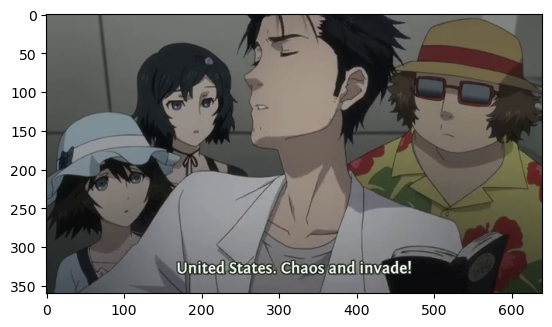

In [10]:
show(frame)

In [15]:
frame_sr = sr(frame)

(1, 360, 640, 1)
Shapes y: (720, 1280) | u: (720, 1280) | v: (720, 1280)


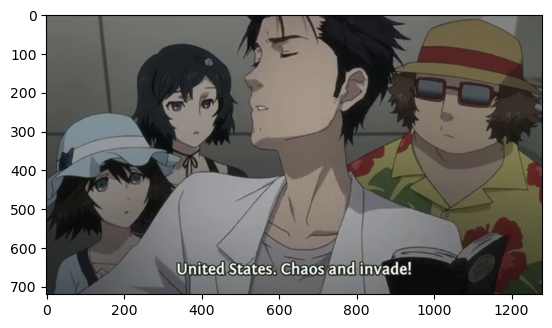

In [16]:
show(frame_sr)

In [17]:
cv2.imwrite("./results/sr_last.png",frame_sr)

True

In [18]:
image2 = cv2.imread("data/gate/frame_0194.png")

In [19]:
frame_sr.shape

(720, 1280, 3)

In [20]:
image2.shape

(720, 1280, 3)

In [21]:
combined_image = np.zeros((frame_sr.shape[0], frame_sr.shape[1]*2, 3), dtype=np.uint8)
combined_image[:frame_sr.shape[0], :frame_sr.shape[1]] = frame_sr
combined_image[:image2.shape[0], frame_sr.shape[1]:] = image2

cv2.putText(combined_image, "SR", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(combined_image, "Original", (frame_sr.shape[1] + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

array([[[111, 109, 107],
        [103, 109, 107],
        [103, 109, 107],
        ...,
        [ 85,  89,  84],
        [ 85,  89,  84],
        [ 85,  89,  84]],

       [[106, 109, 107],
        [111, 109, 107],
        [112, 109, 107],
        ...,
        [ 85,  89,  84],
        [ 85,  89,  84],
        [ 85,  89,  84]],

       [[ 98, 109, 107],
        [122, 109, 107],
        [107, 109, 107],
        ...,
        [ 85,  89,  84],
        [ 85,  89,  84],
        [ 85,  89,  84]],

       ...,

       [[ 23,  40,  38],
        [ 41,  40,  38],
        [ 49,  40,  38],
        ...,
        [ 27,  41,  33],
        [ 28,  42,  34],
        [ 28,  42,  34]],

       [[ 30,  40,  38],
        [ 40,  40,  38],
        [ 31,  40,  38],
        ...,
        [ 28,  42,  34],
        [ 29,  43,  35],
        [ 29,  43,  35]],

       [[ 48,  40,  38],
        [ 37,  40,  38],
        [ 46,  40,  38],
        ...,
        [ 28,  42,  34],
        [ 29,  43,  35],
        [ 29,  43,  35]]

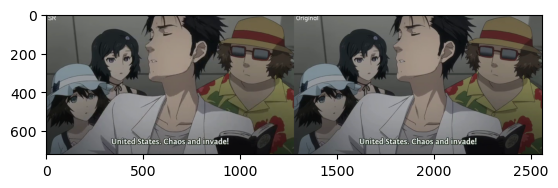

In [22]:
show(combined_image)

In [24]:
cv2.imwrite("results/output_comp.png",combined_image)

True